# The Midwest underwater

A look at 2019 floods in South Dakota, USA

Elsa Culler  
Nate Quarderer  
2025-05-20

## Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace.

In [1]:
%store -r

# Import libraries

## STEP 4: Analyse the flood

As scientists and engineers, we are interested in not just describing a
flood, but in understanding how often we would expect an event that
severe or extreme to happen. Some applications we need this information
for include:

-   Designing and developing engineering standards for bridges and roads
    to withstand flooding
-   Choosing the capacity of water treatment plants to accommodate flood
    waters
-   Computing flood risk maps and choosing where to build
-   Determining flood insurance rates

The exceedance probability is a simple, data-driven way to quantify how
unusual a flood is and how often we can expect similar events to happen.
We calculate exceedance probability by counting how many years with
floods the same size or larger have been recorded, or ranking the and
dividing by the number of years we have records for:

$$P_e = \frac{\text{Annual peak flow rank}}{\text{Years of record}}$$

This value tells us historically what the likelihood was of a flood of a
certain size or larger each year, or the **exceedance probability**. We
can also express how unusual a flood is with the **return period**, or
an amount of time during which we’d expect there to be about one flood
the same size or larger. The return period is the reciprocal of the
exceedance probability:

$$R = \frac{\text{Years of record}}{\text{Annual peak flow rank}}$$

As an example – suppose a streamflow of $10000$ cfs occurs $4$ times
over a 100-year record. The exceedance probability would be
$\frac{4}{100} = .25$ and the return period would be 25 years.

There are advantages and disadvantages to this method of calculating the
**exceedance probability**. On one hand, we are not making any
assumptions about how often floods occur, and there is no way to
extrapolate to a size of flood that has never been observed. On the
other hand, we can’t incorporate any information about how often floods
occur nearby or in other locations, and the data record for streamflow
is often less than the desired lifetime of the built environment.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>You can learn more about exceedance probabilities and return periods
in <a
href="https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/floods-return-period-and-probability/">this
textbook page on the subject</a></p></div></div>

Let’s start by accessing and plotting ALL the data available for this
site. Then we’ll use a return period **statistic** to quantify how
unusual it was.

### Visualize all the streamflow data

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>In the cell below, plot the entire time series of streamflow data,
without any parameters.</p></div></div>


**Final Configuration Loaded:**
{}
Found 'data_home' in environment variables.
🔄 Fetching metadata for article 29087150...
✅ Found 1 files for download.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32866 entries, 1934-10-01 00:00:00+00:00 to 2024-09-30 00:00:00+00:00
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   site_no        32866 non-null  int64  
 1   00060_Mean     32866 non-null  float64
 2   00060_Mean_cd  32866 non-null  object 
 3   00065_Mean     1592 non-null   float64
 4   00065_Mean_cd  1592 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 1.5+ MB


<Axes: title={'center': '90 Years of Streamflow on the Cheyenne River'}, xlabel='Date', ylabel='Streamflow (cfs)'>

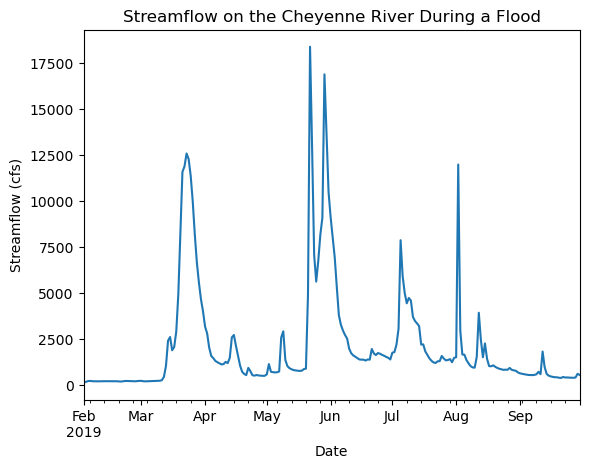

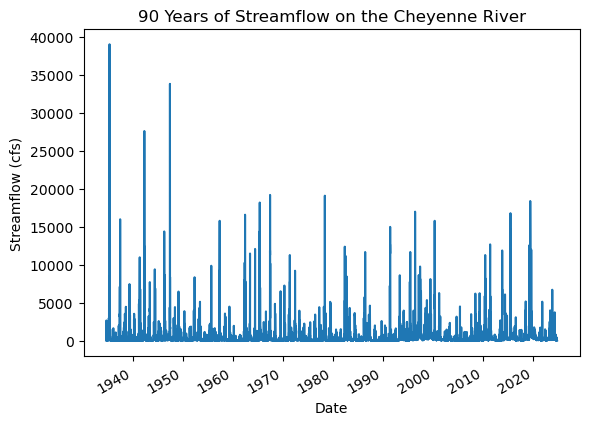

In [2]:
# Import libraries
import earthpy
import geopandas as gpd #vector data
import hvplot.pandas #Interactive plots
import pandas as pd

id = 'stars'
site_name = 'Cheyenne River near Wasta'
year = 2019
project_title = 'Cheyenne River Flood Frequency'
project_dirname = 'flood-cheyenne'

# Create project directory
project = earthpy.Project(title=project_title, dirname='project_dirname')
# Download data
streamflow_path = project.get_data()
# Display the project data directory location
project.project_dir
nwis_path = project.project_dir / 'cheyenne_streamflow_1934_2024.csv'

nwis_df = pd.read_csv(
    nwis_path,
    index_col='datetime',
    parse_dates=True)
nwis_df.info()

discharge_df = (
    nwis_df
    # Select only the discharge column as a DataFrame
    [['00060_Mean']]
    # Rename the discharge column
    .rename(columns={'00060_Mean': 'streamflow_cfs'})
)

discharge_df

flood_df = discharge_df.loc['2019-02':'2019-09']
flood_df

(
    flood_df
    .plot(
        xlabel='Date', 
        ylabel='Streamflow (cfs)',
        title='Streamflow on the Cheyenne River During a Flood',
        legend=False)
)

# Plot the entire streamflow time series
(
    discharge_df
    .plot(
        xlabel='Date', 
        ylabel='Streamflow (cfs)',
        title='90 Years of Streamflow on the Cheyenne River',
        legend=False)
)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Do you notice anything about this plot?</p></div></div>

First things first – this plot looks a little fuzzy because it is trying
to fit too many data points in a small area. There aren’t enough pixels
in this plot to represent all the data points! One way to improve this
is by **resampling** the data to **annual maxima**. That way we still
get the same peak streamflows, but the computer will be able to plot all
the values without overlapping.

> **Tip**
>
> **Resampling** means changing the time interval between time series
> observations - in this case from daily to annual.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Read about <a
href="https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/resample-time-series-data-pandas-python/">different
ways to resample time series data in your textbook</a></p>
<p>You can use a <a
href="https://pandas.pydata.org/docs/dev/user_guide/timeseries.html#timeseries-offset-aliases">list
of <strong>offset aliases</strong></a> to look up how to specify the
final dates. This list is pretty hard to find - you might want to
bookmark it or check back with this page if you need it again.</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Resample your <code>DataFrame</code> to get an annual maximum:</p>
<ol type="1">
<li>Replace <code>dataframe_name</code> with the name of your
<code>DataFrame</code>.</li>
<li>Replace <code>offset_alias</code> with the correct offset alias from
the <a
href="https://pandas.pydata.org/docs/dev/user_guide/timeseries.html#timeseries-offset-aliases">pandas
documentation</a></li>
<li>Save the results to a new, descriptive variable name, and display
the results of the resampling.</li>
</ol></div></div>

In [3]:
# Resample to annual maxima
peaks_df = discharge_df.resample('YS').max()
peaks_df

,streamflow_cfs
datetime,
1934-01-01 00:00:00+00:00,2700.0
1935-01-01 00:00:00+00:00,39000.0
1936-01-01 00:00:00+00:00,1680.0
1937-01-01 00:00:00+00:00,16000.0
1938-01-01 00:00:00+00:00,4500.0
...,...
2020-01-01 00:00:00+00:00,1800.0
2021-01-01 00:00:00+00:00,5170.0
2022-01-01 00:00:00+00:00,1540.0


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Plot your resampled data.</p></div></div>

<Axes: title={'center': 'Annual Maximum Daily Streamflow Values on the Cheyenne River'}, xlabel='Year', ylabel='Daily Streamflow (cfs)'>

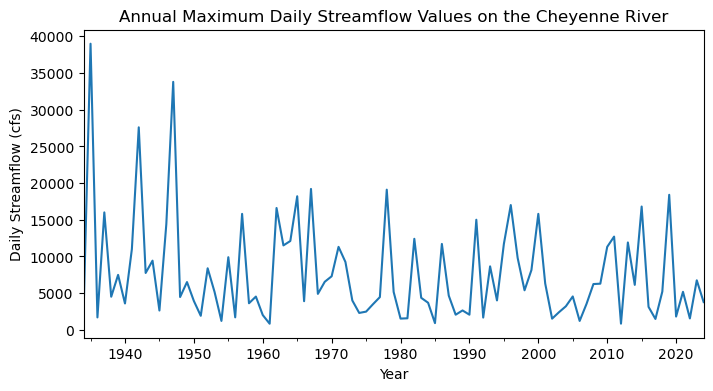

In [4]:
# Plot annual maximum streamflow values
peaks_df.plot(
    figsize=(8, 4),
    xlabel='Year',
    ylabel='Daily Streamflow (cfs)',
    title='Annual Maximum Daily Streamflow Values on the Cheyenne River',
    legend=False)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>Write a headline and 2-3 sentence description of your plot. What is
your visual estimate of the return period was for the flood in 2019?</p></div></div>

YOUR HEADLINE AND PLOT DESCRIPTION HERE

### Select relevant data

When calculating exceedance probabilities, we are making an assumption
of **stationarity**, meaning that all the peak streamflows are drawn
from the same **probability distribution**. Put another way, we only
want to include data from years where the conditions on the river are
similar to what they are now.

Did you notice that the streamflow values from before 1950 or so? You
should investigate any obvious causes of that discrepancy so we know if
the pre-1950 data is relevant to current conditions.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What are some possible causes for peak streamflows to decrease
systematically?</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-info"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Climate Change and Stationarity</div></div><div class="callout-body-container callout-body"><p>One of the problems with adapting to climate change is that we can no
longer assume stationarity in a lot of contexts. As scientists, we don’t
yet have standard methods for incorporating climate change into flood
return period calculations. You can read more about the debate of
stationarity, climate change, and return periods in <a
href="https://www.science.org/doi/10.1126/science.1151915">a paper
called ‘Stationarity is Dead’</a> and the many related response
papers.</p></div></div>

It turns out that construction on the Oahe dam on the Cheyenne River was
started in 1948. We therefor don’t want to include any streamflow
measurements before that date, because the Cheyenne River now as a much
different flood response due to the dam. Dams tend to reduce peak
streamflow, depending on how they are managed, but can cause other
problems in the process.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>Learn more about the Oahe Dam on <a
href="https://en.wikipedia.org/wiki/Oahe_Dam">its Wikipedia page</a>.
You can also find some local perspectives on the dam in some of the
articles about the 2019 flood at the beginning of this coding
challenge.</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Remove years of data before the construction of the Oahe Dam. You can
use a colon inside the square brackets of the <code>.loc</code>
attribute to show that you would like all dates after a certain value,
e.g. <code>'1950':</code></p></div></div>

In [5]:
# Select data from after dam construction
peaks_df = peaks_df.loc['1948':]
peaks_df

,streamflow_cfs
datetime,
1948-01-01 00:00:00+00:00,4460.0
1949-01-01 00:00:00+00:00,6500.0
1950-01-01 00:00:00+00:00,3920.0
1951-01-01 00:00:00+00:00,1900.0
1952-01-01 00:00:00+00:00,8380.0
...,...
2020-01-01 00:00:00+00:00,1800.0
2021-01-01 00:00:00+00:00,5170.0
2022-01-01 00:00:00+00:00,1540.0


### Calculate the exceedance probability and return period for 2019

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-extra"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Looking for an Extra Challenge?</div></div><div class="callout-body-container callout-body"><p>Calculate the <strong>exceedance probability</strong> and
<strong>return period</strong> for each year of the
<strong>annual</strong> data, and add them as columns to your
DataFrame.</p>
<ol type="1">
<li>Replace <code>df</code> with the name of your <strong>annual
maximum</strong> <code>DataFrame</code>.</li>
<li>Replace <code>col</code> with the name of your streamflow
column</li>
<li>Calculate the return period using Python mathematical operators</li>
</ol></div></div>

> **Tip**
>
> When you use a Python mathematical operator on a `pandas.DataFrame`
> column, Python will do the calculation for every row in the
> `DataFrame` automatically!

> **Tip**
>
> When you rank the floods in your `DataFrame` with the `.rank()`
> method, you will need the
> ascending=False`parameter, by default the largest floods will have the higher number. We use`ascending=Falsa\`
> to reverse the rankings, since higher rank should be lower exceedence
> probability.

In [6]:
# Make a copy so this is a dataframe and not a view
peaks_df = peaks_df.copy()

# Calculate exceedance probability
peaks_df['exceed_prob'] = (
    peaks_df.rank(ascending=False).streamflow_cfs 
    / len(peaks_df)
)
# Calculate return period
peaks_df['return_period'] = 1 / peaks_df.exceed_prob

peaks_df

,streamflow_cfs,exceed_prob,return_period
datetime,,,
1948-01-01 00:00:00+00:00,4460.0,0.558442,1.790698
1949-01-01 00:00:00+00:00,6500.0,0.376623,2.655172
1950-01-01 00:00:00+00:00,3920.0,0.623377,1.604167
1951-01-01 00:00:00+00:00,1900.0,0.831169,1.203125
1952-01-01 00:00:00+00:00,8380.0,0.311688,3.208333
...,...,...,...
2020-01-01 00:00:00+00:00,1800.0,0.844156,1.184615
2021-01-01 00:00:00+00:00,5170.0,0.467532,2.138889
2022-01-01 00:00:00+00:00,1540.0,0.896104,1.115942


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Select only the value for 2019.</p>
<ol type="1">
<li>Replace <code>dataframe_name</code> with the name of your
<code>DataFrame</code></li>
<li>Inside the square brackets, type the year you want to select (2019).
Make sure to surround the year with quotes, or Python will interpret
this as a <strong>row number</strong>.</li>
</ol></div></div>

In [7]:
peaks_df.loc['2019']

,streamflow_cfs,exceed_prob,return_period
datetime,,,
2019-01-01 00:00:00+00:00,18400.0,0.038961,25.666667


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-respond"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Reflect and Respond</div></div><div class="callout-body-container callout-body"><p>What is the exceedance probability and return period for the 2019
floods on the Cheyenne River?</p></div></div>

PROBABILITY AND RETURN PERIOD HERE

## Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! This code will store all your variables. You might want to
specify specific variables, especially if you have large objects in
memory that you won’t need in the future.

In [8]:
%store

Stored variables and their in-db values:


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!